# **Detección de Nódulos Pulmonares**

En esta sección se pretende resolver la tarea de Detección de objetos para Localizar Nódulos Pulmonares en radiografías mediante 2 Modelos: Faster R-CNN y RetinaNet. 

El conjunto de Datos se divide en 80% para el Entrenamiento y 20% para el Test, utilizando una resolución de 800×800 píxeles y un Batch Size de 6 debido al alto consumo de memoria de estos modelos. 

El Rendimiento se evalúa principalmente mediante mAP50 junto con el IoU Medio de los true positives, incorporando también Early Stopping para evitar el entrenamiento innecesario.

---

## **Preparación del Entorno y Datos**

### **Configuración Inicial**
Se carga la configuración global, las variables globales y las rutas a los archivos y carpetas necesarias. También se muestra el dispositivo disponible y los hiperparámetros principales.

In [1]:
# Configuración global
import sys

sys.path.append("..")  # subimos un nivel para ver la carpeta src
from src.config import *

print(f"Configuración Cargada, Dispositivo = {DEVICE}")
print(f"Resolución = {DET_IMAGE_SIZE}, Batch Size = {DET_BATCH_SIZE}")
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetHead
from torchvision import ops

import numpy as np
import pandas as pd
from PIL import Image
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm


RESULTS_DIR.mkdir(exist_ok=True)
print("\nEntorno preparado para Detección")

Configuración Cargada, Dispositivo = cuda
Resolución = (800, 800), Batch Size = 6

Entorno preparado para Detección


### **Definición del Dataset**
Se crea la clase DatasetDeteccion, que se encarga de cargar las imágenes .mha, les aplica las transformaciones pertinentes y define las cajas de las imágenes con nódulos.

In [2]:
# Dataset personalizado para la Detección

from src.funcDatos import load_mha_image
import torchvision.transforms as transforms

class DatasetDeteccion(Dataset):

    def __init__(self, df_images_unique, df_full_annotations, transforms=None):

        # Reiniciamos el índice para tener un acceso seguro por posición
        self.df_images = df_images_unique.reset_index(drop=True) 
        self.df_full = df_full_annotations                     
        self.transforms = transforms

    # Devuelve el número total de imágenes en el Dataset
    def __len__(self):        
        return len(self.df_images)

    # Devuelve un elemento correspondiente al índice idx
    def __getitem__(self, idx):
        row = self.df_images.iloc[idx]
        img_name = row['img_name']
        img_path = IMAGE_DIR / img_name
        
        # Cargamos la imagen .mha y la redimensionamos al tamaño DET_IMAGE_SIZE
        img = load_mha_image(img_path, target_size=DET_IMAGE_SIZE)
        
        # Convertimos a tensor para poder aplicar otras transformaciones
        img_tensor = transforms.ToTensor()(img)
        
        # Aplicamos las transformaciones si se especifican
        if self.transforms:
            img_tensor = self.transforms(img_tensor)

        # Seleccionamos las filas que corresponden a la Imagen Actual
        anns = self.df_full[self.df_full['img_name'] == img_name]

        boxes = []
        for _, ann in anns.iterrows():

            # Saltamos filas con alguna dimensión a 0, ya que las imágenes negativas no tienen nódulos
            if ann['width'] <= 0 or ann['height'] <= 0:
                continue
            x, y, w, h = ann['x'], ann['y'], ann['width'], ann['height']
            
            # Escalamos las coordenadas originales (1024x1024) al tamaño DET_IMAGE_SIZE
            x1 = x * DET_IMAGE_SIZE[0] / 1024
            y1 = y * DET_IMAGE_SIZE[1] / 1024
            x2 = (x + w) * DET_IMAGE_SIZE[0] / 1024
            y2 = (y + h) * DET_IMAGE_SIZE[1] / 1024
            
            # Por si acaso, nos aseguramos de que las Dimensiones de la Caja sean Correctas
            if x2 <= x1 or y2 <= y1:
                continue  # Si es incorrecta, la ignoramos
                
            boxes.append([x1, y1, x2, y2])  # Creamos la Caja

        # Hacemos que las Imágenes estén en formato Torchvision para poder aplicar los Algoritmos de Detección
        # Imagen sin nódulos, tensores vacíos
        if len(boxes) == 0:            
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)                 # Cajas
            labels = torch.ones((len(boxes),), dtype=torch.int64)               # Imagen con nódulos es de la clase 1
            areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])   # Área de cada caja
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)             # No hay crowds

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),  # ID Único para la Evaluación
            "area": areas,
            "iscrowd": iscrowd
        }

        return img_tensor, target

### **División del Dataset y Creación de los Dataloaders**
Se separa el conjunto de datos en un dataset para el entrenamiento (80%) y un dataset para el test (20%) de forma estratificada para mantener la proporción de clases.

También se generan los DataLoaders para el entrenamiento y para el test. El de entrenamiento mezcla los datos en cada epoch para obtener aleatoriedad, pero en el de test no es necesario.

In [3]:
# Split de Datos
from src.funcDatos import get_train_test_split


# Hacemos el split 80/20
train_df, test_df, df_full = get_train_test_split(test_size=0.2, random_state=42)

# Creamos los Datasets para el Entrenamiento y para el Test, pasamos df_full para acceder a todas las anotaciones de cada imagen
train_dataset = DatasetDeteccion(train_df, df_full, transforms=None)
test_dataset  = DatasetDeteccion(test_df,  df_full, transforms=None)


# Creamos los Data Loader

# DataLoader para el Entrenamiento
# shuffle = True para evitar el Overfitting
# num_workers = 0 porque da un error con otros valores
# collate_fn personalizado porque los Targets son Diccionarios y no se pueden apilar directamente
train_loader = DataLoader(train_dataset, batch_size=DET_BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

# DataLoader para el Test
test_loader = DataLoader(test_dataset, batch_size=DET_BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

Total Imágenes = 4882
Train tiene 3905 imágenes
Test tiene 977 imágenes
Distribución en Test, Sin Nódulo = 750 | Con Nódulo = 227


## **Funciones de Entrenamiento y Evaluación**

### **Inicialización del Entrenamiento**
Se inicializan los elementos necesarios para el entrenamiento. Se mueve al dispositivo, se crea el optimizador SGD y se inicializan las variables necesarias para detectar el mejor modelo por mAP50 y realizar el early stopping.

In [4]:
# Inicializa y configura el entrenamiento

def initialize_training(model, model_name):

    # Movemos el Modelo al Dispositivo disponible
    model.to(DEVICE)
    
    # Actualizaremos solo los parámetros que necesitan Gradiente para sólo entrenar el Clasificador (no tocamos el Backbone)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
    
    # Inicializamos las Variables para guardar el Mejor Modelo y para realizar el Early Stopping
    best_map50 = 0.0            # Mejor mAP50 encontrado
    best_iou = 0.0              # IoU Medio del mejor Modelo
    best_model_path = RESULTS_DIR / f"mejor{model_name.replace(' ', '_')}.pth"
    
    patience_counter = 0        # Contador para el Early Stopping
    

    print(f"ENTRENANDO y EVALUANDO: {model_name}")
    
    return optimizer, best_map50, best_iou, best_model_path, patience_counter

### **Entrenamiento de un Epoch y Cálculo del mAP50**
Se implementa el bucle del entrenamiento para un solo epoch que actualiza los pesos en cada batch, con una barra de progreso que indica el avance en el epoch actual.

También se define la función que se encarga de calcular el mAP y el IoU medio.

In [5]:
# Entrenamiento de un Epoch completo del Entrenamiento
def train_one_epoch(model, optimizer, train_loader, epoch):

    model.train()
    desc = f"Epoch {epoch+1}/{NUM_EPOCHS} - Entrenando"

    # Iteramos sobre todos los Batches del train_loader
    for images, targets in tqdm(train_loader, desc=desc, leave=False):
        
        # Movemos los datos al dispositivo
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        

        loss_dict = model(images, targets)                  # Pasamos los datos al modelo y obtenemos las distintas Pérdidas (errores)
        losses = sum(loss for loss in loss_dict.values())   # Suma todas las Pérdidas
        
        optimizer.zero_grad()          # Reiniciamos el valor de los Gradientes
        losses.backward()              # Cálculamos los Gradientes con Backward Pass
        optimizer.step()               # Actualizamos los Pesos



# Función para calcular el mAP50 y IoU Medio
def compute_map50(pred_boxes, pred_scores, pred_labels, true_boxes, true_labels, iou_threshold=0.5):

    # Si no hay ninguna predicción, devolvemos un mAP50 y un IoU Medio de 0
    if len(pred_boxes) == 0:
        return 0.0, 0.0
    
    # Ordenamos las Predicciones por Score Descendente (el mayor primero)
    sorted_indices = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[sorted_indices]
    pred_labels = pred_labels[sorted_indices]
    
    # Calculamos el IoU entre todas las Predicciones y todos los Valores Reales
    ious_all = torchvision.ops.box_iou(pred_boxes, true_boxes)
    
    tp = torch.zeros(len(pred_boxes))           #1 si True Positive
    fp = torch.zeros(len(pred_boxes))           #1 si False Positive
    used_gt = torch.zeros(len(true_boxes))
    matched_ious = []                           # Guardamos los IoU de los True Positives
    
    # Recorremos las predicciones una por una
    for i in range(len(pred_boxes)):

        # Si no es de la Clase Positiva (con nódulo), es un FP
        if pred_labels[i] != 1:
            fp[i] = 1
            continue
            
        # Obtenemos los Valores Reales con los que esta Predicción tiene un IoU mayor al iou_threshold
        matches = ious_all[i] >= iou_threshold

        # Si hay al menos 1 coincidencia
        if matches.any():    
            # Índices de los Valores Reales que coinciden
            gt_idx = matches.nonzero(as_tuple=False).squeeze(1)

            if len(gt_idx) > 0:
                # Ordenamos por IoU Descendente para elegir la mejor coincidencia primero
                gt_idx = gt_idx[torch.argsort(ious_all[i][gt_idx], descending=True)]

                # Iteramos sobre todos los índices de los Valores Reales
                for g in gt_idx:

                    # Si el Valor Real no se ha usado aún, asignamos TP a la Predicción y se marca el Índice como Usado
                    if not used_gt[g]:
                        tp[i] = 1
                        used_gt[g] = 1
                        matched_ious.append(ious_all[i][g].item())
                        break
                
                # Si no encontramos ningún Valor Real sin usar, asignamos FP
                if tp[i] == 0:
                    fp[i] = 1
        # Si no hay ninguna coincidencia, FP
        else:
            fp[i] = 1
    
    # Calculamos la cantidad acumulada de TP y FP
    tp_cum = torch.cumsum(tp, dim=0)
    fp_cum = torch.cumsum(fp, dim=0)

    # Los usamos para obtener el Precision y el Recall
    recall = tp_cum / (len(true_boxes) + 1e-8)
    precision = tp_cum / (tp_cum + fp_cum + 1e-8)
    
    # Aproximación del Average Precision
    ap = 0.0
    for t in torch.linspace(0, 1, 11):
        if (recall >= t).any():
            p = precision[recall >= t].max()
        else:
            p = 0.0
        ap += p / 11.0
    
    mean_iou = sum(matched_ious) / len(matched_ious) if matched_ious else 0.0
    return ap, mean_iou


### **Evaluación del Modelo en el Test**
Se realiza la evaluación completa del modelo en el conjunto de test, recopilando las predicciones de mientras se visualiza el avance con una barra de progreso. Se calculan el mAP50 y el IoU Medio de los True Positives.

In [6]:
# Evaluación del Modelo en el Test Set

def evaluate_one_epoch(model, test_loader, epoch):

    model.eval()                        # Activamos el modo Evaluación
    all_pred_boxes = []                 # Cajas Predichas
    all_pred_scores = []                # Scores de cada Predicción
    all_pred_labels = []                # Etiquetas Predichas
    all_true_boxes = []                 # Valores Reales de las Cajas
    all_true_labels = []                # Etiquetas Reales

    desc = f"Epoch {epoch+1}/{NUM_EPOCHS} - Evaluando"

    with torch.no_grad():              # Desactivamos el cálculo de Gradientes para ir más rápido

        # Iteramos sobre todos los Batches del test_loader     
        for images, targets in tqdm(test_loader, desc=desc, leave=False):

            # Movemos las Imágenes al dispositivo y sacamos la Predicción con el Modelo
            images = [img.to(DEVICE) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                # Filtramos las Predicciones por el SCORE_THRESHOLD
                keep = output['scores'] > SCORE_THRESHOLD
                pred_boxes = output['boxes'][keep]
                pred_scores = output['scores'][keep]
                pred_labels = output['labels'][keep]

                # Obtenemos los Valores Reales para esta Imagen
                true_boxes = targets[i]['boxes']
                true_labels = targets[i]['labels']

                # Lo guardamos todo en la RAM (CPU) para el cálculo posterior
                all_pred_boxes.append(pred_boxes.cpu())
                all_pred_scores.append(pred_scores.cpu())
                all_pred_labels.append(pred_labels.cpu())
                all_true_boxes.append(true_boxes.cpu())
                all_true_labels.append(true_labels.cpu())

    # Si no hay Predicciones Válidas, devolvemos 0 y 0
    if len(all_pred_boxes) == 0 or torch.cat(all_pred_boxes).numel() == 0:
        map50 = 0.0
        mean_iou = 0.0
    
    # Si hay Predicciones Válidas, preparamos los Datos y obtenemos el mAP50 y IoU Medio
    else:
        pred_boxes = torch.cat(all_pred_boxes)
        pred_scores = torch.cat(all_pred_scores)
        pred_labels = torch.cat(all_pred_labels)
        true_boxes_all = torch.cat(all_true_boxes)
        true_labels_all = torch.cat(all_true_labels)
        true_boxes = true_boxes_all[true_labels_all == 1]  # Solo los que tengan Nódulos

        map50, mean_iou = compute_map50(pred_boxes, pred_scores, pred_labels, true_boxes, true_labels_all)

    return map50, mean_iou


### **Función Principal del Entrenamiento**
Se define el cuerpo completo del entrenamiento de un modelo con early stopping. Se inicializan los componentes, se ejecuta el entrenamiento y evaluación de los epoch y se guarda el mejor modelo por mAP50, mostrándolo al final.

In [7]:
# Función Principal del Entrenamiento completo con Early Stopping

def train_and_evaluate(model, model_name):

    optimizer, best_map50, best_iou, best_model_path, patience_counter = initialize_training(model, model_name)
    
    # Iteramos para cada Epoch
    for epoch in range(NUM_EPOCHS):
        # Entrenamos 1 Epoch completamente
        train_one_epoch(model, optimizer, train_loader, epoch)
        
        # Evaluamos el Epoch
        map50, mean_iou = evaluate_one_epoch(model, test_loader, epoch)
        
        # Resumen del Epoch
        print(f"Epoch {epoch+1:02d}, mAP50 = {map50:.4f} | IoU medio (TP) = {mean_iou:.4f}")

        # Si tiene el mejor rendimiento hasta la fecha guardamos sus valores
        if map50 > best_map50:
            best_map50 = map50
            best_iou = mean_iou

            # Reiniciamos el valor de la Paciencia (porque hemos encontrado un Modelo que mejora)
            patience_counter = 0

            # Guardamos el Modelo actual 
            torch.save(model.state_dict(), best_model_path)

            print(f"  NUEVO MEJOR MODELO, mAP50 = {best_map50:.4f} | IoU medio = {best_iou:.4f}")
            print(f"  Guardado en {best_model_path}\n")
        
        # Si no es el mejor, no ha mejorado así que incrementamos el contador de Paciencia
        else:
            patience_counter += 1
            print(f"  Sin mejora de mAP50 ({patience_counter}/{PATIENCE})")

            # Early Stopping si no mejora durante PATIENCE Epochs seguidos
            if patience_counter >= PATIENCE:
                print(f"  EARLY STOPPING tras {PATIENCE} Epochs sin mejora")
                break

    # Cargamos el Mejor Modelo
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    
    # Imprimimos el Rendimiento del Mejor Modelo
    print(f"\n\nRESULTADO FINAL - {model_name} (mejor modelo por mAP50)")
    print(f"mAP50 = {best_map50:.4f}")
    print(f"IoU medio = {best_iou:.4f}")

    # Devolvemos las métricas del mejor modelo para hacer la Comparativa Final
    return model, best_map50, best_iou

## **Modelos de Detección**

### **Entrenamiento de Faster R-CNN con Transfer Learning**

In [8]:
# Faster R-CNN Preentrenado en ResNet50-FPN

# Cargamos el Faster R-CNN preentrenado
faster_rcnn = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

# Obtenemos la cantidad de Características de entrada del Clasificador
in_features = faster_rcnn.roi_heads.box_predictor.cls_score.in_features

# Cambiamos el Predictor para que se adapte a nuestro NUM_CLASSES
faster_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=NUM_CLASSES)

# Empezamos el Entrenamiento del Faster R-CNN
faster_rcnn, best_frcnn_map, best_frcnn_iou = train_and_evaluate(faster_rcnn, "Faster R-CNN")

ENTRENANDO y EVALUANDO: Faster R-CNN


Epoch 01, mAP50 = 0.4617 | IoU medio (TP) = 0.6551
  NUEVO MEJOR MODELO, mAP50 = 0.4617 | IoU medio = 0.6551
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorFaster_R-CNN.pth



Epoch 02, mAP50 = 0.5645 | IoU medio (TP) = 0.6737
  NUEVO MEJOR MODELO, mAP50 = 0.5645 | IoU medio = 0.6737
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorFaster_R-CNN.pth



Epoch 03, mAP50 = 0.5935 | IoU medio (TP) = 0.6860
  NUEVO MEJOR MODELO, mAP50 = 0.5935 | IoU medio = 0.6860
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorFaster_R-CNN.pth



Epoch 04, mAP50 = 0.5872 | IoU medio (TP) = 0.6870
  Sin mejora de mAP50 (1/8)


Epoch 05, mAP50 = 0.5846 | IoU medio (TP) = 0.6814
  Sin mejora de mAP50 (2/8)


Epoch 06, mAP50 = 0.5821 | IoU medio (TP) = 0.6848
  Sin mejora de mAP50 (3/8)


Epoch 07, mAP50 = 0.5499 | IoU medio (TP) = 0.6882
  Sin mejora de mAP50 (4/8)


Epoch 08, mAP50 = 0.5707 | IoU medio (TP) = 0.6948
  Sin mejora de mAP50 (5/8)


Epoch 09, mAP50 = 0.5687 | IoU medio (TP) = 0.6894
  Sin mejora de mAP50 (6/8)


Epoch 10, mAP50 = 0.5615 | IoU medio (TP) = 0.6993
  Sin mejora de mAP50 (7/8)


Epoch 11, mAP50 = 0.5594 | IoU medio (TP) = 0.6957
  Sin mejora de mAP50 (8/8)
  EARLY STOPPING tras 8 Epochs sin mejora


RESULTADO FINAL - Faster R-CNN (mejor modelo por mAP50)
mAP50 = 0.5935
IoU medio = 0.6860


### **Entrenamiento de RetinaNet**

In [9]:
# Faster R-CNN Preentrenado en ResNet50-FPN

# Cargamos el Faster R-CNN preentrenado
retinanet = retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT)

# Obtenemos los canales de Salida del Backbone y el número de Anchors por Posición
in_features = retinanet.head.classification_head.cls_logits.in_channels
num_anchors = retinanet.head.classification_head.num_anchors

# Cambiamos el head de RetinaNet para que se adapte a nuestro NUM_CLASSES
retinanet.head = torchvision.models.detection.retinanet.RetinaNetHead(
    in_channels=retinanet.backbone.out_channels, num_anchors=retinanet.head.classification_head.num_anchors, num_classes=NUM_CLASSES
)

# Empezamos el Entrenamiento del RetinaNet
retinanet, best_retina_map, best_retina_iou = train_and_evaluate(retinanet, "RetinaNet")

ENTRENANDO y EVALUANDO: RetinaNet


Epoch 01, mAP50 = 0.0988 | IoU medio (TP) = 0.6254
  NUEVO MEJOR MODELO, mAP50 = 0.0988 | IoU medio = 0.6254
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorRetinaNet.pth



Epoch 02, mAP50 = 0.0000 | IoU medio (TP) = 0.0000
  Sin mejora de mAP50 (1/8)


Epoch 03, mAP50 = 0.3831 | IoU medio (TP) = 0.6390
  NUEVO MEJOR MODELO, mAP50 = 0.3831 | IoU medio = 0.6390
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorRetinaNet.pth



Epoch 04, mAP50 = 0.4201 | IoU medio (TP) = 0.6330
  NUEVO MEJOR MODELO, mAP50 = 0.4201 | IoU medio = 0.6330
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorRetinaNet.pth



Epoch 05, mAP50 = 0.5125 | IoU medio (TP) = 0.6466
  NUEVO MEJOR MODELO, mAP50 = 0.5125 | IoU medio = 0.6466
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorRetinaNet.pth



Epoch 06, mAP50 = 0.5487 | IoU medio (TP) = 0.6608
  NUEVO MEJOR MODELO, mAP50 = 0.5487 | IoU medio = 0.6608
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorRetinaNet.pth



Epoch 07, mAP50 = 0.5619 | IoU medio (TP) = 0.6543
  NUEVO MEJOR MODELO, mAP50 = 0.5619 | IoU medio = 0.6543
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorRetinaNet.pth



Epoch 08, mAP50 = 0.5754 | IoU medio (TP) = 0.6611
  NUEVO MEJOR MODELO, mAP50 = 0.5754 | IoU medio = 0.6611
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorRetinaNet.pth



Epoch 09, mAP50 = 0.5885 | IoU medio (TP) = 0.6708
  NUEVO MEJOR MODELO, mAP50 = 0.5885 | IoU medio = 0.6708
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorRetinaNet.pth



Epoch 10, mAP50 = 0.5808 | IoU medio (TP) = 0.6712
  Sin mejora de mAP50 (1/8)


Epoch 11, mAP50 = 0.5641 | IoU medio (TP) = 0.6754
  Sin mejora de mAP50 (2/8)


Epoch 12, mAP50 = 0.5307 | IoU medio (TP) = 0.6533
  Sin mejora de mAP50 (3/8)


Epoch 13, mAP50 = 0.5996 | IoU medio (TP) = 0.6752
  NUEVO MEJOR MODELO, mAP50 = 0.5996 | IoU medio = 0.6752
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorRetinaNet.pth



Epoch 14, mAP50 = 0.5529 | IoU medio (TP) = 0.6663
  Sin mejora de mAP50 (1/8)


Epoch 15, mAP50 = 0.5976 | IoU medio (TP) = 0.6649
  Sin mejora de mAP50 (2/8)


Epoch 16, mAP50 = 0.5850 | IoU medio (TP) = 0.6730
  Sin mejora de mAP50 (3/8)


Epoch 17, mAP50 = 0.5860 | IoU medio (TP) = 0.6783
  Sin mejora de mAP50 (4/8)


Epoch 18, mAP50 = 0.5865 | IoU medio (TP) = 0.6760
  Sin mejora de mAP50 (5/8)


Epoch 19, mAP50 = 0.5565 | IoU medio (TP) = 0.6746
  Sin mejora de mAP50 (6/8)


Epoch 20, mAP50 = 0.6058 | IoU medio (TP) = 0.6784
  NUEVO MEJOR MODELO, mAP50 = 0.6058 | IoU medio = 0.6784
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorRetinaNet.pth



Epoch 21, mAP50 = 0.5730 | IoU medio (TP) = 0.6834
  Sin mejora de mAP50 (1/8)


Epoch 22, mAP50 = 0.5740 | IoU medio (TP) = 0.6765
  Sin mejora de mAP50 (2/8)


Epoch 23, mAP50 = 0.5674 | IoU medio (TP) = 0.6837
  Sin mejora de mAP50 (3/8)


Epoch 24, mAP50 = 0.5802 | IoU medio (TP) = 0.6778
  Sin mejora de mAP50 (4/8)


Epoch 25, mAP50 = 0.5609 | IoU medio (TP) = 0.6864
  Sin mejora de mAP50 (5/8)


Epoch 26, mAP50 = 0.5761 | IoU medio (TP) = 0.6719
  Sin mejora de mAP50 (6/8)


Epoch 27, mAP50 = 0.5824 | IoU medio (TP) = 0.6743
  Sin mejora de mAP50 (7/8)


Epoch 28, mAP50 = 0.5648 | IoU medio (TP) = 0.6786
  Sin mejora de mAP50 (8/8)
  EARLY STOPPING tras 8 Epochs sin mejora


RESULTADO FINAL - RetinaNet (mejor modelo por mAP50)
mAP50 = 0.6058
IoU medio = 0.6784


### **Guardado de los Resultados**
Se recopilan las métricas de rendimiento finales de ambos modelos entrenados, se agrupan en un DataFrame y se guardan en un archivo CSV dentro de la carpeta results.

In [10]:
# Guardamos los resultados

# Recopilamos los resultados de los 2 Modelos
all_results = []

# Resultados de Faster R-CNN
all_results.append({
    'model': 'Faster R-CNN',
    'mAP50': float(best_frcnn_map),     # Convertimos tensor a float puro para el CSV
    'MediaIoU': float(best_frcnn_iou)
})

# Resultados de RetinaNet
all_results.append({
    'model': 'RetinaNet',
    'mAP50': float(best_retina_map),    # Convertimos tensor a float puro para el CSV
    'MediaIoU': float(best_retina_iou)
})

# Creamos un DataFrame ordenado
results_df = pd.DataFrame(all_results)
results_df = results_df[['model', 'mAP50', 'MediaIoU']]
results_df = results_df.round(4)  # Redondeamos a 4 decimales

# Guardamos el archivo .csv en la carpeta results/
results_path = RESULTS_DIR / "resultadosDeteccion.csv"
results_df.to_csv(results_path, index=False)

print(f"Resultados de los 2 Modelos guardados en {results_path}")

print("\nVista previa:")
display(results_df)

Resultados de los 2 Modelos guardados en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\resultadosDeteccion.csv

Vista previa:


,model,mAP50,MediaIoU
0,Faster R-CNN,0.5935,0.6860
1,RetinaNet,0.6058,0.6784


## **Comparativa Final**

### **Carga de Resultados**
Se carga el archivo .csv de resultados, se ordena por mAP50 descendente y se muestra una tabla ordenada con las métricas de todos los modelos.

In [11]:
# Cargamos los resultados que se encuentran en el .csv

results_path = RESULTS_DIR / "resultadosDeteccion.csv"

if not results_path.exists():
    print(f"No se encontró el archivo {results_path}, ejecuta primero el Entrenamiento de los 2 Modelos y Genera los Resultados.")
else:
    # Cargamos los resultados del archivo .csv
    df_results = pd.read_csv(results_path)
    
    # Los Ordenamos por mAP50 de manera Descendente (mejor modelo arriba)
    df_table = df_results.sort_values('mAP50', ascending=False).reset_index(drop=True)
    
    print("Resultados Cargados y Ordenados por mAP50:")
    print(df_table.to_string(index=False))

Resultados Cargados y Ordenados por mAP50:
       model  mAP50  MediaIoU
   RetinaNet 0.6058    0.6784
Faster R-CNN 0.5935    0.6860


### **Gráfico Comparativo de mAP50 y IoU Medio**

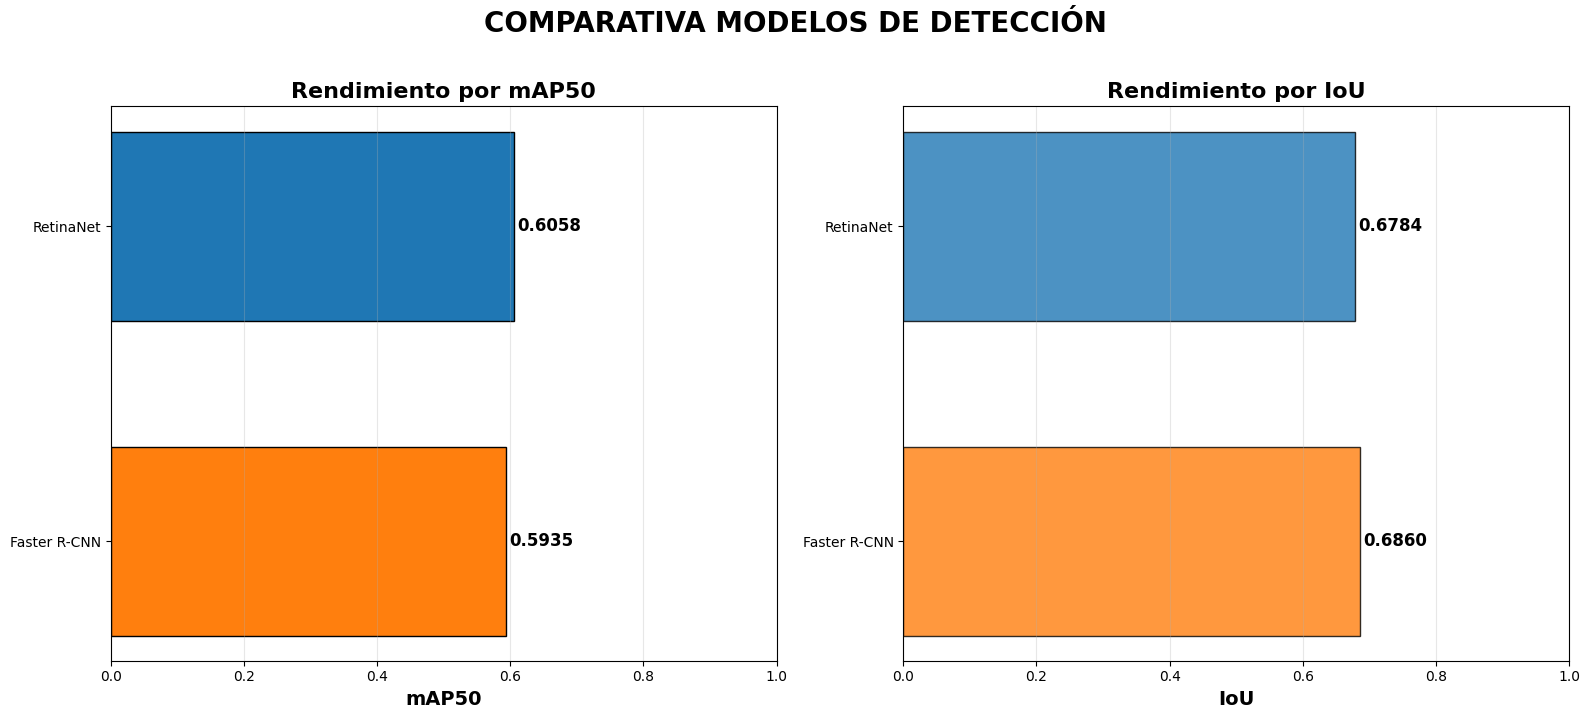

In [12]:
# Gráfico para comparar mAP50 y IoU Medio

if 'df_table' in globals():    
    # Creamos la figura con 2 Subplots Horizontales
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle('COMPARATIVA MODELOS DE DETECCIÓN', fontsize=20, fontweight='bold', y=1.02)
    
    # Definimos la paleta de colores que usaremos
    colors = ['#1f77b4', '#ff7f0e']

    # Gráfico 1, comparación por mAP50
    bars1 = ax1.barh(df_table['model'], df_table['mAP50'], color=colors, edgecolor='black', height=0.6)
    ax1.set_xlabel('mAP50', fontsize=14, fontweight='bold')
    ax1.set_title('Rendimiento por mAP50', fontsize=16, fontweight='bold')
    ax1.set_xlim(0, 1)
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()  # Mejor modelo arriba
    
    # Añadimos el valor de cada uno en las barras
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{width:.4f}', va='center', fontweight='bold', fontsize=12)
    
    # Gráfico 2, IoU Medio
    bars2 = ax2.barh(df_table['model'], df_table['MediaIoU'], color=colors, alpha=0.8, edgecolor='black', height=0.6)
    ax2.set_xlabel('IoU', fontsize=14, fontweight='bold')
    ax2.set_title('Rendimiento por IoU', fontsize=16, fontweight='bold')
    ax2.set_xlim(0, 1)
    ax2.grid(axis='x', alpha=0.3)
    ax2.invert_yaxis()
    
    # Añadimos el valor de cada uno en las barras
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{width:.4f}', va='center', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()